# Observational Causal Inference Simulation : Panel Data Analysis

*If you see any errors / mistakes or suggestions, please feel free to reach out! The information below is based on the knowledge I had at the time of the last update.*

## Updates Log:

- 2023-11-06 : Initial Draft
- 2023-11-07 : Added more reading notes to (imai and kim, 2019)

## Table of Contents

1. Introduction
2. Simple Cross-Sectional Data Example
3. Panel Data Example
4. More on "Fixed Effects": improvements, alternate methods, standard errors, etc.,
5. Industry Example

## 1. Introduction

Panel data analysis in observational causal inference is a class of methods used for analyzing effects that take place over multiple treatment periods for each user. In a cross-sectional study, a user is exposed to treatment once and then the outcome is looked at one time and we base our results off of that study.

Often times (depending on the field/industry/product), cross-sectional studies may not be sufficient. For instance, if we are trying to analyze the continuous effect of social media feed engagement on future visitation, it might make more sense to visualize multiple engagement patterns overtime.

Another reason why panel data is popular, especially in econometrics, is because the methods used have the promise of naturally controlling for unobserved time-invariant confounders ([Imai and Kim, 2019](https://imai.fas.harvard.edu/research/FEmatch.html)). Of-course, this doesn't "solve" causal inference because all observational causal inference analysis relies on untestable assumptions ([Pearl, 2009](https://www.cs.princeton.edu/courses/archive/fall09/cos597A/papers/Pearl2009.pdf)), and panel data methods are no exception, although different method differ in their assumptions. However, unobserved confounders are a big pain point and being able to relieve at least the time-invariant ones can feel attractive.

Below, we'll do some simple simulations to "visualize" this effect, then dive into a bit of the nuances, and then top it off with an industry example.



### Load Packages

In [ ]:
# all Python libraries:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.special import expit
import warnings
warnings.filterwarnings('ignore')
from itertools import product
%matplotlib inline

In [ ]:
#!pip install linearmodels
from linearmodels.panel import PanelOLS

In [ ]:
# Load R
# Guide here: https://colab.research.google.com/drive/1ISG891i076enSPB-4bni_DECWlFlnasU?usp=sharing
%reload_ext rpy2.ipython
%config IPCompleter.greedy=True
%config InlineBackend.figure_format = 'retina'

In [ ]:
%%R
#install.packages('wfe')
#install.packages('plm')
#install.packages('ggdag')
#install.packages('stargazer')

NULL


In [ ]:
%%R
library('wfe')
library('plm')
library('ggdag')
library('ggplot2')
library('stargazer')

## 2. Cross-Sectional Data Example

Before simulating Panel Data, we'll first visualize how regression can be used to control for confounders in cross-sectional data. In this kind of data format, there is one row per user and the user receives treatment just once.

We will work with the simplest case of Binary Treatment $T$ with outcome $Y$ and a singular confounder $X$.

We can visualize this using a DAG. I also read this fun paper going over all the DAG packages as of 2023 ([Pitts and Fowler, 2023](https://arxiv.org/pdf/2305.12006.pdf)).

Note that the following structure makes the explicit assumption that there is only one confounder, but of-course in real problems this won't really ever be the case.

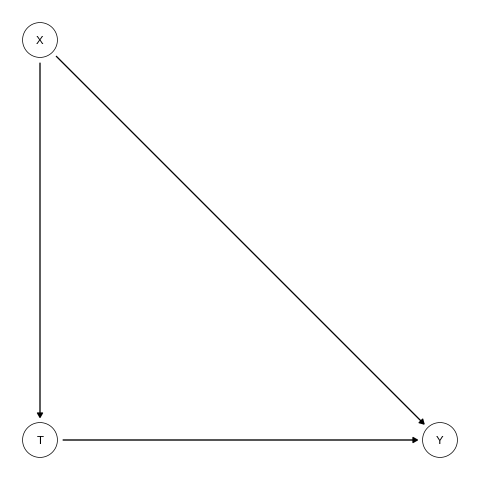

In [ ]:
%%R
dag2 <- dagify(
    # relations
    Y ~ T + X,
    T ~ X,
    # exposure and outcome
    exposure = 'T', outcome = 'Y',
    # location
    coords = list(
        x = c(Y = 2, T = 1, X = 1),
        y = c(Y = 1, T = 1, X = 2)
    )
)
dag2 %>% ggplot(
    aes(x=x, y=y, xend=xend, yend=yend)
) +
geom_dag_point(shape=1) +
geom_dag_edges_arc(
    curvature = c(0, 0, 0)
) +
theme_void() +
geom_dag_text(
    # subscripts
    color = 'black',
    parse = TRUE,
    label = c('T','X','Y')
)

The variables have the following formulation:
- $X_i\sim\text{Normal}(0,1)$
- $T_i\sim\text{Bernoulli}(\text{logit}(X_i))$

and
$$Y_i = 2T_i+X_i+\epsilon_i$$
where $\epsilon_i\sim\text{Normal}(0,1)$

This means that the treatment effect on the outcome is $2$.

In [ ]:
# simulate a simple cross-sectional data
N = 2000

#create dataframe with confounder X
p = pd.DataFrame(
    {
        'X': np.random.normal(0,1,size=N),
    }
)

# add treatment and outcome
p['T'] = np.random.binomial(1,expit(p['X']),size=N)
p['Y'] = 2*p['T'] + p['X'] + np.random.normal(0,1,size=N)

# show a snippet
p.head()

,X,T,Y
0,-2.099627,0,-2.393284
1,-0.285380,1,2.335167
2,1.614574,1,4.276460
3,-0.855574,0,-0.511614
4,0.297266,1,1.183325


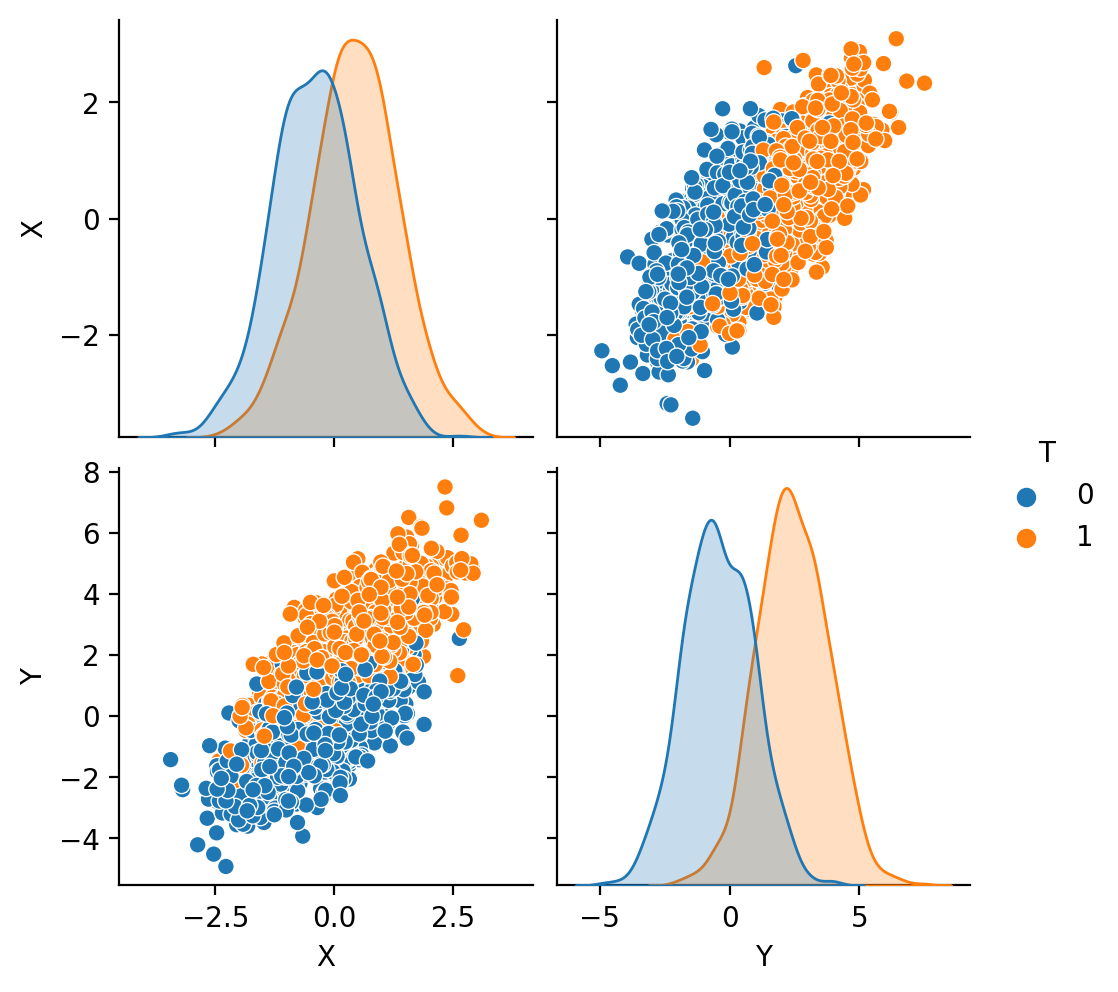

In [ ]:
# visualize data
sns.pairplot(p,hue='T')

Now let's run 2 regressions, one where we only regress $Y$ on treatment $T$ and another where we also include the confounder $X$.

In [ ]:
%%R -i p
stargazer(
    lm(Y~T,data=p),
    lm(Y~T+X,data=p),
    digits=3,
    type='text', # the only way to print results of stargazer using rpy2 on a notebook I think
    title = 'Linear Regression Models for Simulated Cross-Sectional Data: True Effect: T = 2',
    model.numbers=FALSE,
    column.labels = c('Y~T','Y~T+X')
)


Linear Regression Models for Simulated Cross-Sectional Data: True Effect: T = 2
                                      Dependent variable:                  
                    -------------------------------------------------------
                                               Y                           
                                Y~T                        Y~T+X           
---------------------------------------------------------------------------
T                            2.861***                    2.026***          
                              (0.061)                     (0.049)          
                                                                           
X                                                        1.017***          
                                                          (0.025)          
                                                                           
Constant                     -0.435***                    -0.032           
       

Notice how when not controlling for $X$, it overestimates the effect of $T$ greatly due to confounding, but when we included all covariates then the estimate looked fine. This is because $X$ affects both the outcome $Y$ as well as the treatment $T$.

Of-course, regression is not the only method of controlling for confounders. In fact, using *only* regression is actually not best practice because by using regression you're actually invoking even more assumptions than necessary, such as the assumption of correct model specification. Ways to deal with this includes methods like Matching ([Ho et al., 2007](https://gking.harvard.edu/files/matchp.pdf))

## 3. Panel Data Example

Unlike cross-sectional data where there are $N$ rows, one for each entity, in (balanced) panel data we have $N\times T$ rows, one for each entity *and* time period, where $T\geq 2$ (It's usually not a requirement that the data is balanced - balanced means that there are $T$ time periods for each user instead of some having less due to something like a no-show).

When scouring the econometrics text, it usually discusses several different types of estimators for panel regression but then follows it up with saying that the previous methods are not used anymore - I believe the reason why researchers include the previous work is for pedogogical reasons - it makes the overall concept easier to understand.

Some resources that helped me personally:
- [Introduction to Econometrics in R, Chapter 10.3](https://www.econometrics-with-r.org/10.3-fixed-effects-regression.html)
- [The Effect: An Introduction to Research Design and Causality, Chapter 16](https://theeffectbook.net/ch-FixedEffects.html)
- [Causal Inference for the Brave and True, Chapter 14](https://matheusfacure.github.io/python-causality-handbook/14-Panel-Data-and-Fixed-Effects.html)
- [Panel Data Using R](https://www.princeton.edu/~otorres/Panel101R.pdf)

In a popular panel data method called Fixed Effects, the data is assumed to have the following composition:
$$Y_{it}=\alpha_i+\beta X_{it}+\epsilon_{it}$$

Notice how $\alpha_i$ is unique in that it is not time-varying. Intuitively, this means that $\alpha_i$ are properties of each user that doesn't change over time. An example would be ethnicity if $i$ represented a user. More on $\alpha$ later.

The fascinating property of fixed effects regression is that it promises to control for *unobserved* time-*invariant* confounders. What this means is that we don't actually have to know $\alpha_i$, it will still be controlled for. We will demonstrate this below using code (Of-course, we know the true value of $\alpha_i$ because we simulated the data, but we will show below what the estimates look like when we don't know $\alpha_i$)

The data will have the following data generation format:
- $X_{it}\sim\text{Normal}(0,1)$
- $\alpha_i\sim\text{Normal}(0,1)$
- $T_i\sim\text{Bernoulli}(\text{logit}(X_{it}+\alpha_i))$

and
$$Y_{it} = \alpha_i+2T_{it}+X_{it}+\epsilon_{it}$$
where $\epsilon_{it}\sim\text{Normal}(0,1)$

In [ ]:
N = 1000; T = 5

# use product() to get all combinations of individual and time
# This is taken from https://theeffectbook.net/ch-Simulation.html so check out the link for more info!
panel = pd.DataFrame(
    product(range(0,N),range(0,T))
)

panel.columns = ['userid','time']

# time and unit varying confounders
panel['X'] = np.random.normal(size=N*T)

# time-invariant confounder
unit_data = pd.DataFrame({
    'userid' : range(0,N),
    'a' : np.random.normal(size = N)
})

# Combine
panel = panel.merge(unit_data, on = 'userid')

# treatment
panel['T'] = np.random.binomial(1,expit(panel['X'] + panel['a']),size=N*T)

# outcome
panel['Y'] = 2*panel['T'] + panel['X'] + panel['a'] + np.random.normal(0,1,size=N*T)

# show a snippet
panel.head(7)

,userid,time,X,a,T,Y
0,0,0,-1.344030,1.678021,0,-1.177471
1,0,1,-1.201661,1.678021,1,1.824557
2,0,2,-1.460205,1.678021,0,1.050471
3,0,3,-0.513280,1.678021,1,2.507024
4,0,4,-0.600480,1.678021,1,2.570594
5,1,0,1.575957,-0.367849,0,2.897988
6,1,1,-0.019348,-0.367849,0,-0.134249


Let's first try to use regular regression

In [ ]:
%%R -i panel
stargazer(
    lm(Y~T,data=panel),
    lm(Y~T+X,data=panel),
    digits=3,
    type='text', # the only way to print results of stargazer using rpy2 on a notebook I think
    title = 'Linear Regression Models for Simulated Panel Data: True Effect: T = 2',
    model.numbers=FALSE,
    column.labels = c('Y~T','Y~T+X')
)


Linear Regression Models for Simulated Panel Data: True Effect: T = 2
                                      Dependent variable:                  
                    -------------------------------------------------------
                                               Y                           
                                Y~T                        Y~T+X           
---------------------------------------------------------------------------
T                            3.357***                    2.749***          
                              (0.045)                     (0.041)          
                                                                           
X                                                        0.874***          
                                                          (0.020)          
                                                                           
Constant                     -0.722***                   -0.419***         
                 

We see here how the coefficient of $T$ is very off - the unobserved time-invariant confounder $\alpha_i$ is introducing bias to our estimate.

How about instead we use (weighted) linear fixed effects?

In [ ]:
%%R -i panel
print(wfe(Y ~ T+X, data = panel, treat = "T",unit.index = "userid",time.index = "time",method="unit",qoi = "ate",hetero.se=TRUE,auto.se=TRUE,White = TRUE,White.alpha = 0.05))

 
Number of unique unit is 1000 

Weight calculation started Weight calculation done 
Call:
wfe(formula = Y ~ T + X, data = panel, treat = "T", unit.index = "userid", 
    time.index = "time", method = "unit", qoi = "ate", hetero.se = TRUE, 
    auto.se = TRUE, White = TRUE, White.alpha = 0.05)

Coefficients:
       T        X 
1.937862 1.015463 

Std.Err:
[1] 0.03853643 0.02044059


We see here how even though we didn't include $\alpha_i$ into our model, our treatment estimate was accurately extracted. This demonstrates how fixed effects controlls for unobserved time-invariant confounders.

## 4. More on "Fixed Effects": improvements, alternate methods, etc.,

### A quick note on the sister of fixed effects - random effects

(The following paragraph is paraphrasing a section of this page: [link](https://theeffectbook.net/ch-FixedEffects.html).)
There's actually what's also called "Random Effects". Instead of letting the intercept freely vary across users ($\alpha_i$), we instead assume that it comes from some random distributon, such as assuming that it's normal. Adding an assumption like this allows the precision of your estimate to be higher. However, in the simplest form of Random effects, for it to have the causal property that Fixed effects does, you have to assume that $\alpha_i$ is unrelated to $X_{it}$. Of-course, this is often not a reasonable assumption. Apparently there is a test called the "Durbin-Wu-Hausman test" which tells you if you should use Fixed Effects or Random Effects. For further text on how Random Effects have been improved over time, definitely check out the link above.

### A quick note on standard errors for fixed effects models

(Also from the link above) In regards to standard errors, you may have noticed that regular standard errors wouldn't work because it assumes that all data points (rows) were sampled independently. This is not true because in panel data you sample the same user multiple times. Thus, you typically use clustered standard errors that takes this into consideration. However, the decision to use clustered standard errors is a bit nuanced so it is worth reading about ([Abadie et al., 2017](https://www.nber.org/system/files/working_papers/w24003/w24003.pdf)).

### (Imai and Kim, 2019) When Should We Use Unit Fixed Effects Regression Models for Causal Inference with Longitudinal Data?

Here, I'll put some high-level notes from ([Imai and Kim, 2019](https://imai.fas.harvard.edu/research/files/FEmatch.pdf)), the people who created the package I used above, `wfe`. The paper goes over a lot of modifications to the fixed effects while showing its equivalence to the matching estimator to help make clear which alternate forms are making what kind of different assumptions. This was probably the paper that I found to be most useful for understanding panel data methods, but I also think it's not too friendly for those who have no familiarity with panel methods. However, if you've reached this far in the notebook, you're probably good to read the paper.

To start off, they note:
>*Many researchers use these (panel) models to adjust for unobserved, unit-specific and time-invariant confounders when estimating causal effects from observational data. In spite of this widespread practice, much methodological discussion of unit fixed effects models in political science has taken place from model-based perspectives (often assuming linearity), with little attention to the causal identification assumptions*

In their paper, they do just that - discuss causal identification using DAGs and the potential outcomes framework. In addition, due to its equivalence to matching estimators, they are able to find computationally efficient methods for calculating standard errors.

First, the authors start with a fixed effects with the linearity assumption relaxed by showing the model in a nonparametric DAG form, which possesses the ability to control for unobserved time-invariant confounders, but induces the following assumptions:
- (a.) No unobserved time-*varying* confounders
- (b.) Past outcomes do not directly affect current outcome
- (c.) Past outcomes do not directly affect current treatment
- (d.) Past treatments do not directly affect current outcome

Then, the author discusses how and which of these assumptions can be relaxed while still retaining a causal interpretation.

First, they note that assumption (a.) is difficult to relax under the FE model and therefore should just focus on the other 3.

Assumption (b.) is safe to relax because past outcomes do not confound the relation between current treatment and current outcome (as long as we condition on past treatments and unobserved time-invariant confounders).

For Assumption (d.), researchers try to address this by adding a lagged treatment variable in the linear fixed effects model, such as:
$$Y_{it}=\alpha_i+\beta_1X_{it}+\beta_2X_{i,t-1}+\epsilon_{it}$$
This *partially* relaxes the assumption. Due to the difficulties of accounting for *all* past treatments, researchers instead just assume that only a small number of past treatments matter.

For Assumption (c.), the issue is that a causal relationship between past outcomes and current treatment implies a correlation between past disturbance terms and current treatment. To address this issue, a model that has attracted some attention is the linear unit fixed effects model with a lagged outcome variable, as follows:
$$Y_{it}=\alpha_i+\beta X_{it}+\rho Y_{i,t-1}+\epsilon_{it}$$
The standard identification strategy commonly employed for this model is based on instrumental variables.

Then, the authors go into detail on how this can all be expressed using the matching framework. They show how while the linear unit fixed effects model can not consistently estimate the ATE due to its linearity assumption, the weighted unit fixed effects model can.

This leads to an intuitive specification test where you run both the linear and weighted fixed effects model, and the null hypothesis is that the linear unit fixed effects regression model is correct.












## 5. Industry Example

LinkedIn's Data Science team published a paper ([Bojinov et al., 2019](https://arxiv.org/pdf/1903.07755.pdf)) regarding how they used fixed effects for a causal inference analysis regarding how Feed engagement affects future visitation. The paper goes into detail on the assumptions utilized as well as performing various methods (including doubly robust methods by using a cross-sectional version of their data) and comparing the results along with the naive correlation analysis.

Something covered in this paper that I didn't see in other panel literature were how they dealt with network effects, which is particularly important for companies like LinkedIn to keep in mind when performing causal inference work due to the nature of their product.

There were a few things that didn't make sense to me, which I wasn't sure if it was a typo or me not having enough understanding of panel methods. But overall, this paper was paramount to helping me understand how to use panel methods in the industry.